# Model inspection and visualization

This notebook is used to visualize the fully-connected neural network's first layer weights. This was done to gain some insight in the importance of certain features for this network.

In [ ]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_MODELS, PATH_METADATA

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean
import zarr

MODEL_NAME = 'Fully_connected_regressor_FINAL_LOCAL.hdf5'

model_path = os.path.join(PATH_MODELS, MODEL_NAME)
loaded_model = tf.keras.models.load_model(model_path)

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
weights = loaded_model.get_weights()

In [4]:
weights[0].shape

(15030, 500)

In [5]:
n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)


def fully_connected_model():
    """ Returns the fully connected model from Ismail Fawaz et al. (2019). """

    input_layer = keras.layers.Input(input_shape)

    input_layer_flattened = keras.layers.Flatten()(input_layer)

    layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
    layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

    layer_2 = keras.layers.Dropout(0.2)(layer_1)
    layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

    layer_3 = keras.layers.Dropout(0.2)(layer_2)
    layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

    output_layer = keras.layers.Dropout(0.3)(layer_3)
    output_layer = keras.layers.Dense(1)(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = fully_connected_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 501, 30)]         0         
_________________________________________________________________
flatten (Flatten)            (None, 15030)             0         
_________________________________________________________________
dropout (Dropout)            (None, 15030)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               7515500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0     

In [6]:
def get_first_weights():
    for lay in loaded_model.layers:
        w = lay.get_weights()
        if len(w) > 0:
            return w[0]

The get_weights() function returns the weights (for each node to all inputs) and the biases. Our get_first_weights() returns only the weights (15030, 500) of the first Dense layer.

Then, we have a flattened (501, 30) input of 15030 for each node. We take the mean weight of all the weights to determine the importance of a single feature.

After this, the weights array can be 'unflattened' again to its original shape.

In [7]:
# Names and the order of the channels
channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
               'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
               'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']

In [40]:
unflattened_mean_weights = np.mean(get_first_weights(), axis=1).reshape(input_shape)
unflattened_mean_weights = np.swapaxes(unflattened_mean_weights,0,1)
unflattened_mean_weights = np.absolute(unflattened_mean_weights)

In [41]:
# unflattened_df = pd.DataFrame(np.swapaxes(unflattened_mean_weights,0,1))
# # unflattened_df = pd.DataFrame(unflattened_mean_weights)
# unflattened_df.columns = channel_set

# save_path = "/Users/bbruns/Desktop/"
# csv_name = f"fully_connected_abs_weights.csv"

# unflattened_df.to_csv(path_or_buf=os.path.join(save_path, csv_name), sep=',', index=False)

## 1. Visualize all time steps and channels

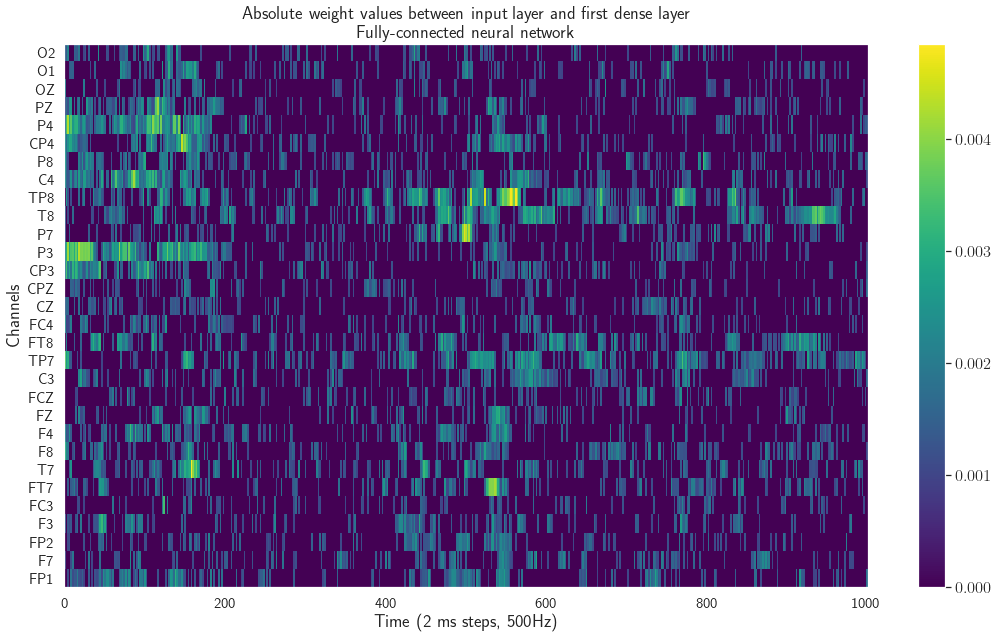

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

sns.set(font_scale=1.5, rc={'text.usetex' : True})

fig, ax = plt.subplots(figsize=(18, 10))
ax.grid(False)

clipping_unflattened_mean_weights = unflattened_mean_weights.copy()
clipping_unflattened_mean_weights[clipping_unflattened_mean_weights < 0.001] = 0

im = ax.imshow(clipping_unflattened_mean_weights, cmap=plt.get_cmap('viridis'), aspect='auto', interpolation='nearest')


plt.yticks(range(len(channel_set)), channel_set, size='small')
plt.xticks([0, 100, 200, 300, 400, 500], ['0', '200', '400', '600', '800', '1000'], size='small')

plt.title(f'Absolute weight values between input layer and first dense layer \n Fully-connected neural network')
plt.xlabel('Time (2 ms steps, 500Hz)')
plt.ylabel('Channels')

cbar = fig.colorbar(im, ax=ax)

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_abs_weights.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

# plt.show()

## 2a. Visualize all channels over all time steps

In [315]:
mean_weights_channel = np.mean(unflattened_mean_weights, axis=1)
# median_weights_channel = np.median(unflattened_mean_weights, axis=1)

In [374]:
mean_weights_channel[9] / mean_weights_channel[0]

3.0952494

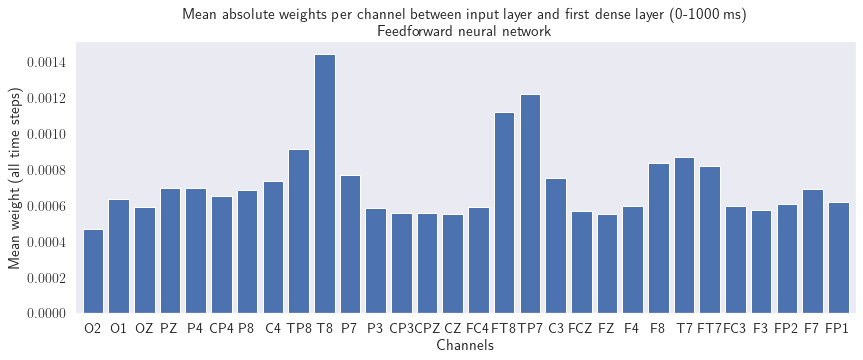

In [363]:
sns.set(font_scale=1.3, rc={'text.usetex' : True})

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (0-1000 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weight (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

## 2b. Visualize channels in 200ms time steps

In [364]:
channel_timesplit = np.array_split(unflattened_mean_weights, 5, axis=1)

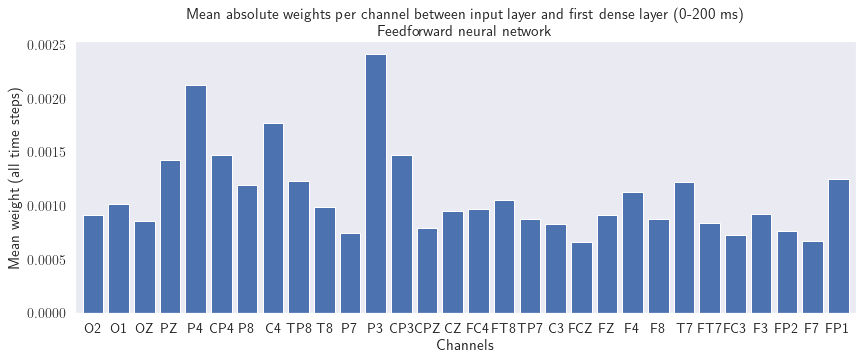

In [365]:
mean_weights_channel = np.mean(channel_timesplit[0], axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (0-200 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weight (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel-0200.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

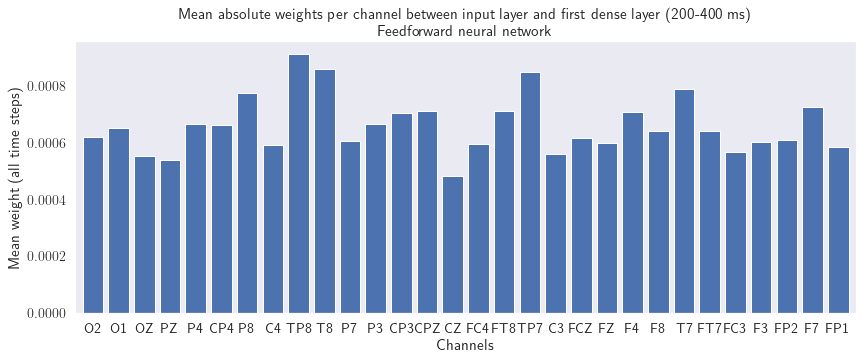

In [366]:
mean_weights_channel = np.mean(channel_timesplit[1], axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (200-400 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weight (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel-200400.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

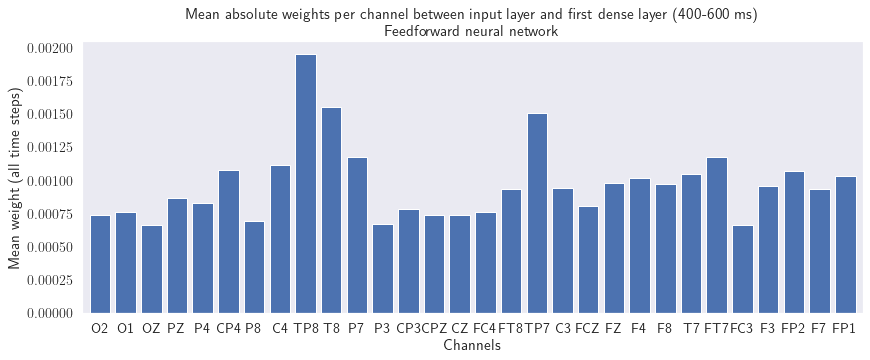

In [367]:
mean_weights_channel = np.mean(channel_timesplit[2], axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (400-600 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weight (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel-400600.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

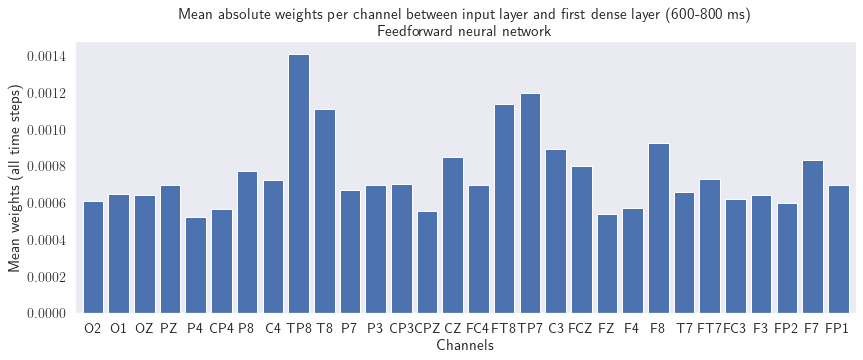

In [368]:
mean_weights_channel = np.mean(channel_timesplit[3], axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (600-800 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weights (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel-600800.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

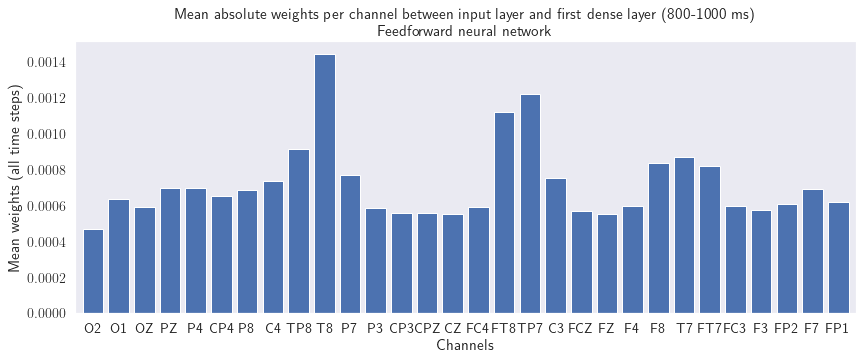

In [369]:
mean_weights_channel = np.mean(channel_timesplit[4], axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid(False)

ax.bar(channel_set, mean_weights_channel)

plt.margins(x=0.01)
plt.title('Mean absolute weights per channel between input layer and first dense layer (800-1000 ms) \n Feedforward neural network')
plt.xlabel('Channels')
plt.ylabel('Mean weights (all time steps)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_channel-8001000.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

## 3. Visualize time steps average over all channels

In [370]:
mean_weights_timepoint = np.mean(unflattened_mean_weights, axis=0)
rolling_mean_weights_timepoint = pd.DataFrame(mean_weights_timepoint).rolling(10).mean()

# median_weights_timepoint = np.median(unflattened_mean_weights, axis=0)
# rolling_median_weights_timepoint = pd.DataFrame(median_weights_timepoint).rolling(10).mean()

In [371]:
# mean_weights_timepoint.shape
# rolling_mean_weights_timepoint

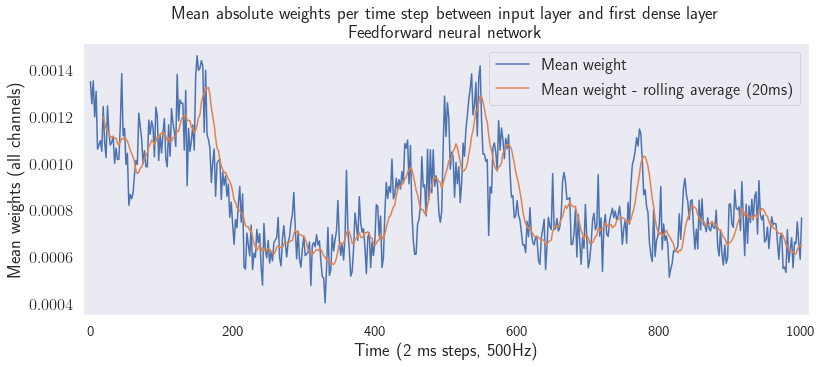

In [380]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.grid(False)

ax.plot(mean_weights_timepoint, label="Mean weight")
ax.plot(rolling_mean_weights_timepoint, label="Mean weight - rolling average (20ms)")
# ax.plot(median_weights_timepoint, label="Median weight")
# ax.plot(rolling_median_weights_timepoint, label="Rolling average - median (10 time steps)")

plt.legend(loc="upper right")

plt.margins(x=0.01)
plt.title('Mean absolute weights per time step between input layer and first dense layer \n Feedforward neural network')
plt.xticks([0, 100, 200, 300, 400, 500], ['0', '200', '400', '600', '800', '1000'], size='small')
plt.xlabel('Time (2 ms steps, 500Hz)')
plt.ylabel('Mean weights (all channels)')

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/Weights/"
fig_name = f"Fully_connected_mean_time.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')